**Question 2.1**<br> 
In this part, you will build a model to forecast the hourly carpark availability in the future
(aggregated across all carparks instead of looking at each carpark individually). Can you
explain why you may want to forecast the carpark availability in the future? Who would
find this information valuable? What can you do if you have a good forecasting model?


We can find out the potential number of cars on the street at one time as well as the general patterns of people.

This is valuable in particular for governments to plan around things such as erp pricing or road maintainence.

With a good model, any emergency work to be done can be scheduled for a period where there are lesser cars on the road, or if there needs to be a system wide upgrade for carpark systems.

**Question 2.2**<br>
Build a linear regression model to forecast the hourly carpark availability for a given
month. Use the month of July 2022 as a training dataset and the month of August 2022
as the test dataset. For this part, do not use additional datasets. The target is the hourly
carpark availability percentage and you will have to decide what features you want to
use. Generate two plots: (i) Time series plot of the actual and predicted hourly values
(ii) Scatter plot of actual vs predicted hourly values (along with a line showing how good
the fit is).

In [1]:
import requests
import json
import pandas as pd
from datetime import datetime
from time import sleep
import os
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
from sklearn import datasets, metrics
from pathlib import Path
from sklearn.metrics import mean_squared_error

# Convert to datetime iso
def toIso(dt):
    return datetime.fromisoformat(dt)

def carparkApiCall(year, month, day, hour, minute, second, error_count):
    def find_local_file(year, month, day, hour, fDir):
        myDir = Path('./data/')
        filePaths = [file for file in myDir.iterdir() if file.name.startswith(f'{year}{month}{day}T{hour.zfill(2)}')]
        is_file_local = False
        for file in filePaths:
            if os.path.isfile(file): #check if file exist
                open(file, 'r')
                fDir = file
                is_file_local = True
                break
        return fDir,is_file_local

    def print_api_error(year, month, day, hour, minute, second, error_count, data):
        print(data)
        print(year,'/', month, '/', day, 'T', hour, minute, second)
        print("error count:", error_count)

    def write_to_file(fDir, data):
        timestamp = data["items"][0]["timestamp"]
        data = data["items"][0]["carpark_data"]
                #create file if response is valid
        os.makedirs(os.path.dirname('./data/'), exist_ok=True)
        with open(fDir, 'w') as fp:
            json.dump(data, fp)
        return data

    def read_from_file(fDir):
        # read from file    
        df = pd.read_json(fDir)
        for heading in ("total_lots","lot_type","lots_available"):
            df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])
        
        # Transform data
        df = df.drop(["carpark_info"], axis=1)
        df['update_datetime'] = df['update_datetime'].apply(toIso)
        df["lots_available"] = df["lots_available"].astype(int)
        df["total_lots"] = df["total_lots"].astype(int)
        return df
    
    max_fail_count = 50
    fDir = f'./data/{year}{month}{day}T{hour.zfill(2)}{minute.zfill(2)}{second.zfill(2)}.json'
    fDir, is_file_local = find_local_file(year, month, day, hour, fDir)
    
    if not is_file_local: # If file doesn't exist, api call
        site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{minute.zfill(2)}%3A{second.zfill(2)}'
        response_API = requests.get(site)
        data = response_API.text
        data = json.loads(data)
        
        #check if response is valid
        if response_API.ok and "items" in data and "timestamp" in data["items"][0] and "carpark_data" in data["items"][0]:
            data = write_to_file(fDir, data)
        else:
            error_count+=1
            print_api_error(year, month, day, hour, minute, second, error_count, data)
            if error_count<=max_fail_count:
                return carparkApiCall(year, month, day, hour, minute, second, error_count)
            else:
                f'Api call failed more than {max_fail_count} times :('
            
    df = read_from_file(fDir)
    return df

# Calculate average availability in percentage
def avrAvail(df):
    df["availability_percentage"] = df["lots_available"]/df["total_lots"]
    return df["availability_percentage"].sum()/len(df.index)

In [2]:
#train set - july

# start date 1 Jul 2022 0001

year = 2022
month = 7
day = 1
hour = 0
minute = 1
second = 0

dt = datetime(year, month, day, hour, minute, second)
dt_interval = timedelta(hours = 1)
total_hrs = 24*30

# day of week,time of day
train_x = []
# avalibility percentage
train_y = []

# generate data
for hr in range(total_hrs):
    dt = dt + dt_interval
    try:
        df = carparkApiCall(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second), 0)
        # day_hour = int(f"{int(df.loc[0,'update_datetime'].weekday())}")
        # hour = int(f"{df.loc[0,'update_datetime'].time().hour}")
        train_x.append([int(dt.weekday()), int(dt.hour)])
        train_y.append(avrAvail(df))
    except:
        print(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second))
train_x = np.array(train_x)

In [3]:
#test set - august

# start date 1 Aug 2022 0002

year = 2022
month = 8
day = 1
hour = 0
minute = 1
second = 0

dt = datetime(year, month, day, hour, minute, second)
dt_interval = timedelta(hours = 1)
time_intervals = 24*30

# day of week,time of day
test_x = []
# avalibility percentage
test_y = []

# generate data
for _ in range(time_intervals):
    dt = dt + dt_interval
    try:
        df = carparkApiCall(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second), 0)
        test_y.append(avrAvail(df))
        # day_hour = int(f"{int(df.loc[0,'update_datetime'].weekday())}")
        # hour = int(f"{df.loc[0,'update_datetime'].time().hour}")
        test_x.append([int(dt.weekday()), int(dt.hour)])
    except:
        print(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second))
    
    

0.003060235251977984 2


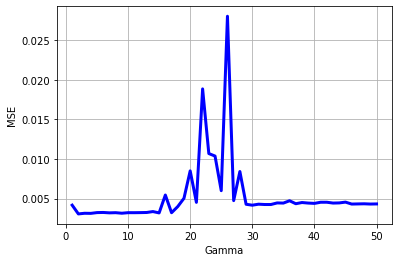

In [4]:
import sklearn.linear_model as lm
from sklearn.preprocessing import PolynomialFeatures
start = 1
dim = start
final_dim = 0
mse_arr = []
mse = 99999999999999999
def linear_regressor(dim):
    poly = PolynomialFeatures(dim)
    train_x_poly = poly.fit_transform(train_x.reshape(-1,2))
    test_x_poly = poly.fit_transform(np.asarray(test_x).reshape(-1,2))
    regressor = lm.LinearRegression()  
    regressor.fit(train_x_poly, train_y) #training the algorithm
    # print(regressor.coef_)
    predicted = regressor.predict(test_x_poly)
    return regressor,mean_squared_error(train_y, predicted)

while dim<=50:     
    temp_regressor,temp_mse = linear_regressor(dim)
    mse_arr.append(temp_mse)
    if temp_mse<mse:
        regressor = temp_regressor
        final_dim = dim
        mse = temp_mse
    dim += 1
print(mse,final_dim)
plt.plot([x for x in range(start,len(mse_arr)+start)], mse_arr, color="blue", linewidth=3)
plt.grid(True)
plt.xlabel("Gamma")
plt.ylabel("MSE")
plt.show()


0.003060235251977984


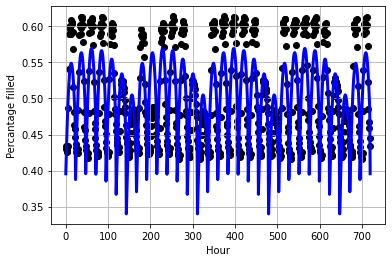

In [5]:
poly = PolynomialFeatures(final_dim)
test_x_poly = poly.fit_transform(np.asarray(test_x).reshape(-1,2))
predicted = regressor.predict(test_x_poly)
print(mean_squared_error(train_y, predicted))
# Plot outputs
plt.scatter([x for x in range(len(test_y))], test_y, color="black")
plt.plot([x for x in range(len(predicted))], predicted, color="blue", linewidth=3)

plt.grid(True)
plt.xlabel("Hour")
plt.ylabel("Percantage filled")

plt.show()

**Question 2.3**<br>
Do the same as Question 2.2 above but use support vector regressor (SVR).


In [6]:
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

sc_X = StandardScaler()
sc_y = StandardScaler()
train_x_scaled = sc_X.fit_transform(train_x.reshape(-1, 2))
train_y_scaled = sc_y.fit_transform(np.asarray(train_y).reshape(-1, 1))
test_x_scaled = sc_X.fit_transform(np.array(test_x).reshape(-1,2))
test_y_scaled = sc_y.fit_transform(np.array(test_y).reshape(-1,1))

In [7]:
start = 1
gamma = start
c = 0
final_c = 0
final_gamma = 0
mse_arr = []
gamma_arr = []
c_arr = []
mse = 99999999999999999
regressor = SVR(kernel='rbf',gamma = 1)

while gamma<20:
    c=0.01
    while c<1:
        temp_regressor = SVR(kernel='rbf',gamma = gamma,C=c)
        temp_regressor.fit(train_x_scaled, train_y_scaled.ravel())
        predicted = temp_regressor.predict(test_x_scaled)
        temp_mse = mean_squared_error(test_y_scaled, predicted)
        c_arr.append(c)
        gamma_arr.append(gamma)
        mse_arr.append(temp_mse)
        if temp_mse < mse:
            mse = temp_mse
            regressor = temp_regressor
            final_gamma = gamma
            final_c = c
        c += 0.01
    gamma += 1


mse: 0.06122647130752073 c: 0.9700000000000006 gamma: 10


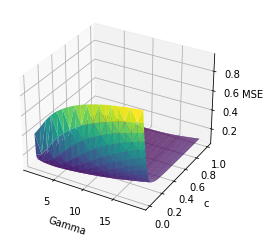

In [8]:
print("mse:",mse,"c:",final_c,"gamma:",final_gamma)
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
ydata = np.asarray(c_arr)
zdata = np.asarray(mse_arr)
xdata = np.asarray(gamma_arr)
ax.plot_trisurf(xdata, ydata, zdata, edgecolor='none', cmap='viridis')

plt.grid(True)
ax.set_xlabel("Gamma")
ax.set_ylabel("c")
ax.set_zlabel("MSE")
plt.show()

mse: 0.06122647130752073


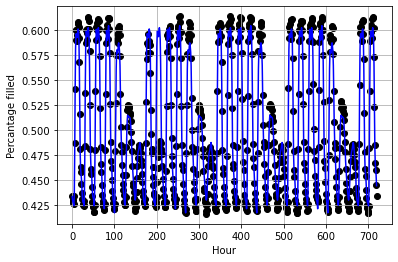

In [9]:
predicted = regressor.predict(test_x_scaled)
print("mse:",mean_squared_error(test_y_scaled, predicted))
predicted = sc_y.inverse_transform(predicted.reshape(-1,1))
plot_y = sc_y.inverse_transform(test_y_scaled)

plt.plot([x for x in range(len(predicted))], predicted, color="blue") # predicted
# plt.plot(x_grid, predicted, color="blue", linewidth=3)
plt.scatter([y for y in range(len(plot_y))], plot_y, color="black") #actual
plt.grid(True)
plt.xlabel("Hour")
plt.ylabel("Percantage filled")
plt.show()

**Question 2.4**<br>
Do the same as Question 2.2 above but use decision tree (DT) regressor.

0.0013996318444756215 2


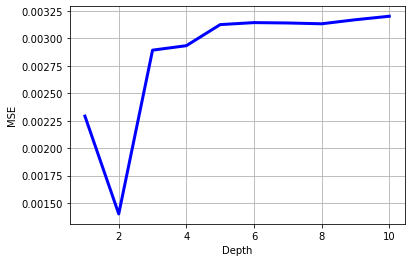

In [10]:

# import the regressor
from sklearn.tree import DecisionTreeRegressor 
  
# create a regressor object
start = 1
depth = start
final_depth = 0
mse_arr = []
mse = 99999999999999999

  
while depth<=10: 
    temp_regressor = DecisionTreeRegressor(max_depth=depth) 
    # fit the regressor with X and Y data
    temp_regressor.fit(train_x.reshape(-1, 2), train_y)
    #5 Predicting a new result
    predicted = temp_regressor.predict(np.asarray(test_x).reshape(-1, 2))
    temp_mse = mean_squared_error(train_y, predicted)
    mse_arr.append(temp_mse)
    if mse > temp_mse:
        mse = temp_mse
        regressor = temp_regressor
        final_depth = depth
    depth += 1

print(mse,final_depth)
plt.plot([x for x in range(start,len(mse_arr)+start)], mse_arr, color="blue", linewidth=3)
plt.grid(True)
plt.xlabel("Depth")
plt.ylabel("MSE")
plt.show()

0.0013996318444756215


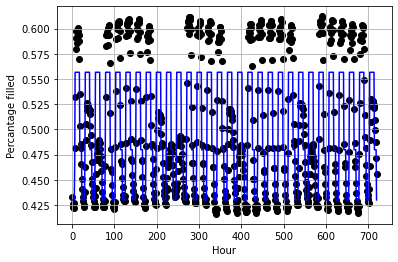

In [11]:
predicted = regressor.predict(np.asarray(test_x).reshape(-1, 2))
print(mean_squared_error(train_y, predicted))

plt.plot([x for x in range(len(predicted))], predicted, color="blue") # predicted
# plt.plot(x_grid, predicted, color="blue", linewidth=3)
plt.scatter([y for y in range(len(train_y))], train_y, color="black") #actual
plt.grid(True)
plt.xlabel("Hour")
plt.ylabel("Percantage filled")
plt.show()

**Question 2.5**<br>
Make a final recommendation for the best regression model (out of the 3 methods above)
by choosing a suitable performance metric. To ensure a fair comparison, carry out hyper-parameter tuning for all 3 methods. Then, make a final recommendation selecting only
one model. Include both quantitative and qualitative arguments for your choice.
